In [2]:
!pip install pretty_midi
!pip install kagglehub


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import warnings
import pretty_midi 
import numpy as np
import pandas as pd
import seaborn as sns
import kagglehub as kagglehub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [4]:
DATA_DIR  = os.path.join('.', 'data')
COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

In [5]:
#path = kagglehub.dataset_download("blanderbuss/midi-classic-music")
#print("Path to dataset files:", path)

In [ ]:
warnings.filterwarnings("ignore")

def extract_midi_features(data_dir, composers, sequence_length=5000, verbose=True):
    """
    Extracts a comprehensive set of musical features from MIDI files stored in subdirectories by composer.

    Parameters:
    - data_dir (str): Path to the root directory containing composer-named subdirectories with MIDI files.
    - composers (list): List of composer names (e.g., ['Bach', 'Beethoven']).
    - sequence_length (int): Maximum sequence length (in frames) for temporal features like piano roll and chroma.
    - verbose (bool): Whether to print logs for skipped files and final count.

    Returns:
    - pd.DataFrame: DataFrame where each row contains features extracted from a MIDI file, useful for EDA and ML modeling.
    """

    supported_ext = (".mid", ".midi")  # Valid file types
    midi_data = []  # List of dictionaries containing features for each file

    for composer in composers:
        composer_dir = os.path.join(data_dir, composer)  # Path to that composer's folder

        for file in os.listdir(composer_dir):
            file_path = os.path.join(composer_dir, file)
            file_lower = file.lower().strip()

            if file_lower.endswith(supported_ext):
                try:
                    midi = pretty_midi.PrettyMIDI(file_path)  # Parse the MIDI file

                    # Collect all non-drum notes from all instruments
                    all_notes = [note for instr in midi.instruments if not instr.is_drum for note in instr.notes]
                    all_notes.sort(key=lambda n: n.start)  # Sort notes chronologically

                    # Extract note-level raw data
                    pitches = [n.pitch for n in all_notes]  # MIDI pitch number (21-108 typically)
                    durations = [n.end - n.start for n in all_notes]  # How long each note is held
                    velocities = [n.velocity for n in all_notes]  # Attack intensity (0-127)
                    iois = [all_notes[i].start - all_notes[i - 1].start for i in range(1, len(all_notes))]  # Inter-onset intervals

                    # Matrix: start, pitch, duration, velocity — useful for time series input to RNNs/LSTMs
                    note_seq_matrix = np.array([[n.start, n.pitch, n.end - n.start, n.velocity] for n in all_notes])

                    # Piano roll matrix: shape (128 pitches x sequence_length) — good for CNN input or audio synthesis
                    piano_roll = midi.get_piano_roll(fs=50)  # Frame rate: 50 frames per second
                    piano_roll = np.pad(piano_roll, ((0, 0), (0, max(0, sequence_length - piano_roll.shape[1]))))[:, :sequence_length]

                    # Chroma matrix: 12 pitch classes (C, C#, ..., B) x time — useful for analyzing harmonic structure
                    chroma = midi.get_chroma(fs=50)
                    chroma = np.pad(chroma, ((0, 0), (0, max(0, sequence_length - chroma.shape[1]))))[:, :sequence_length]

                    # Onset matrix: binary matrix showing when each note starts — useful for rhythm detection
                    onset = np.zeros_like(piano_roll)
                    for n in all_notes:
                        start_idx = int(n.start * 50)
                        if start_idx < sequence_length:
                            onset[n.pitch, start_idx] = n.velocity

                    # Rhythm: 1D binary vector showing presence of any note at a time step — can be used for tempo/rhythm classification
                    rhythm = (np.sum(onset, axis=0, keepdims=True) > 0).astype(int)

                    # Global features from tempo/key/time signature changes — useful for sequence-level classifiers
                    tempos = midi.get_tempo_changes()[1]
                    tempo = tempos[0] if tempos.size else 120  # Use default tempo if not specified
                    key_sig = midi.key_signature_changes[0].key_number if midi.key_signature_changes else None  # 0=C major
                    time_sig = midi.time_signature_changes[0] if midi.time_signature_changes else None  # e.g., 4/4

                    # Append extracted features to the list
                    midi_data.append({
                        # Label
                        "composer": composer,  # Target label for classification

                        # Metadata
                        "file_path": file_path,

                        # General sequence stats — useful for understanding complexity of the piece
                        "duration": midi.get_end_time(),  # Total length in seconds
                        "num_instruments": len(midi.instruments),  # Could indicate orchestration complexity
                        "num_notes": len(pitches),  # Size of the note sequence
                        "note_density": len(pitches) / midi.get_end_time() if midi.get_end_time() > 0 else None,  # Notes/sec

                        # Velocity dynamics — useful for expression/emotion detection
                        "avg_velocity": np.mean(velocities) if velocities else None,

                        # Pitch statistics — key for melodic range and composer style
                        "min_pitch": min(pitches) if pitches else None,
                        "max_pitch": max(pitches) if pitches else None,
                        "avg_pitch": np.mean(pitches) if pitches else None,
                        "most_common_pitch": max(set(pitches), key=pitches.count) if pitches else None,

                        # Duration of notes — style indicator (e.g., legato vs staccato)
                        "avg_note_duration": np.mean(durations) if durations else None,
                        "std_note_duration": np.std(durations) if len(durations) > 1 else 0,

                        # Timing between notes — useful for rhythm and pacing
                        "avg_ioi": np.mean(iois) if iois else None,
                        "std_ioi": np.std(iois) if iois else None,

                        # Musical metadata
                        "tempo": tempo,  # Beats per minute
                        "key_signature": key_sig,  # 0=C major, etc.
                        "time_signature": f"{time_sig.numerator}/{time_sig.denominator}" if time_sig else None,

                        # Deep learning inputs (not directly usable in tabular ML models)
                        "note_sequence": note_seq_matrix,
                        "piano_roll": piano_roll,
                        "chroma": chroma,
                        "onset": onset,
                        "rhythm": rhythm
                    })

                except Exception as e:
                    print(f"[ERROR] Failed to load '{file_path}': {e}")

            else:
                if verbose:
                    print(f"[SKIP] Unsupported file format: {file_path}")

    # Convert to DataFrame for easy EDA and model feeding
    df = pd.DataFrame(midi_data)

    if verbose:
        print(f"\n Loaded metadata for {len(df)} MIDI files.\n")

    return df



# Function to split dataset
def split_dataset(df, test_size=0.3, val_size=0.5, stratify_col="composer", random_state=42):
    train_df, temp_df = train_test_split(df, test_size=test_size, stratify=df[stratify_col], random_state=random_state)
    val_df, test_df = train_test_split(temp_df, test_size=val_size, stratify=temp_df[stratify_col], random_state=random_state)
    return train_df, val_df, test_df

# Function to perform EDA and show visualizations
def perform_eda(df):
    print("Basic Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nSample Records:")
    display(df.head())

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x="duration", hue="composer", kde=True, element="step", bins=40)
    plt.title("Distribution of MIDI Duration by Composer")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x="composer", y="num_notes")
    plt.title("Boxplot of Notes Count by Composer")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x="composer", y="tempo")
    plt.title("Boxplot of Tempo by Composer")
    plt.show()

# Function to preprocess and clean the data
def preprocess_data(df):
    df_clean = df.copy()
    df_clean = df_clean[df_clean['duration'] > 0]
    df_clean = df_clean[df_clean['num_notes'] > 0]
    df_clean = df_clean[df_clean['tempo'] > 0]
    df_clean['log_duration'] = np.log1p(df_clean['duration'])
    df_clean['log_notes'] = np.log1p(df_clean['num_notes'])
    return df_clean


In [15]:
df_midi = extract_midi_features(DATA_DIR, COMPOSERS)

[SKIP] Unsupported file format: .\data\Bach\readme.html
[ERROR] Failed to load '.\data\Beethoven\Anhang 14-3.mid': Could not decode key with 3 flats and mode 255
[SKIP] Unsupported file format: .\data\Beethoven\Sonata No.1 in D.zip
[ERROR] Failed to load '.\data\Mozart\K281 Piano Sonata n03 3mov.mid': Could not decode key with 2 flats and mode 2

✅ Loaded metadata for 1635 MIDI files.



In [16]:
train_df, val_df, test_df = split_dataset(df_midi)

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1635 entries, 0 to 1634
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   composer           1635 non-null   object 
 1   file_path          1635 non-null   object 
 2   duration           1635 non-null   float64
 3   num_instruments    1635 non-null   int64  
 4   num_notes          1635 non-null   int64  
 5   note_density       1635 non-null   float64
 6   avg_velocity       1635 non-null   float64
 7   min_pitch          1635 non-null   int64  
 8   max_pitch          1635 non-null   int64  
 9   avg_pitch          1635 non-null   float64
 10  most_common_pitch  1635 non-null   int64  
 11  avg_note_duration  1635 non-null   float64
 12  std_note_duration  1635 non-null   float64
 13  avg_ioi            1635 non-null   float64
 14  std_ioi            1635 non-null   float64
 15  tempo              1635 non-null   float64
 16  key_signatur

,composer,file_path,duration,num_instruments,num_notes,note_density,avg_velocity,min_pitch,max_pitch,avg_pitch,...,avg_ioi,std_ioi,tempo,key_signature,time_signature,note_sequence,piano_roll,chroma,onset,rhythm
0,Bach,.\data\Bach\003706b_.mid,46.956456,4,304,6.474083,96.0,45,76,60.944079,...,0.139905,0.236754,92.000129,9.0,4/4,"[[1.9565190000000001, 69.0, 0.6521729999999999...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Bach,.\data\Bach\003806b_.mid,45.000000,4,253,5.622222,96.0,38,74,60.992095,...,0.173611,0.321197,96.000000,21.0,4/4,"[[0.0, 71.0, 1.25, 96.0], [0.0, 64.0, 1.25, 96...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Bach,.\data\Bach\003907bv.mid,42.500000,4,285,6.705882,96.0,40,76,59.182456,...,0.145246,0.250267,96.000000,7.0,4/4,"[[0.0, 67.0, 0.625, 96.0], [0.0, 62.0, 0.625, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Bach,.\data\Bach\003907b_.mid,42.500000,4,285,6.705882,96.0,43,79,62.182456,...,0.145246,0.250267,96.000000,10.0,4/4,"[[0.0, 70.0, 0.625, 96.0], [0.0, 65.0, 0.625, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Bach,.\data\Bach\004003b_.mid,30.000000,4,204,6.800000,96.0,42,74,61.220588,...,0.132389,0.205244,96.000000,19.0,4/4,"[[1.875, 67.0, 0.3125, 96.0], [1.875, 62.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


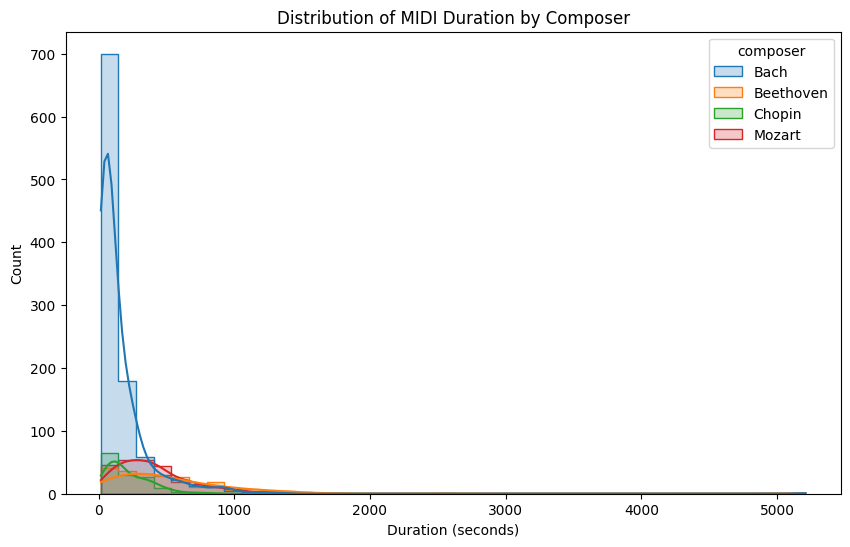

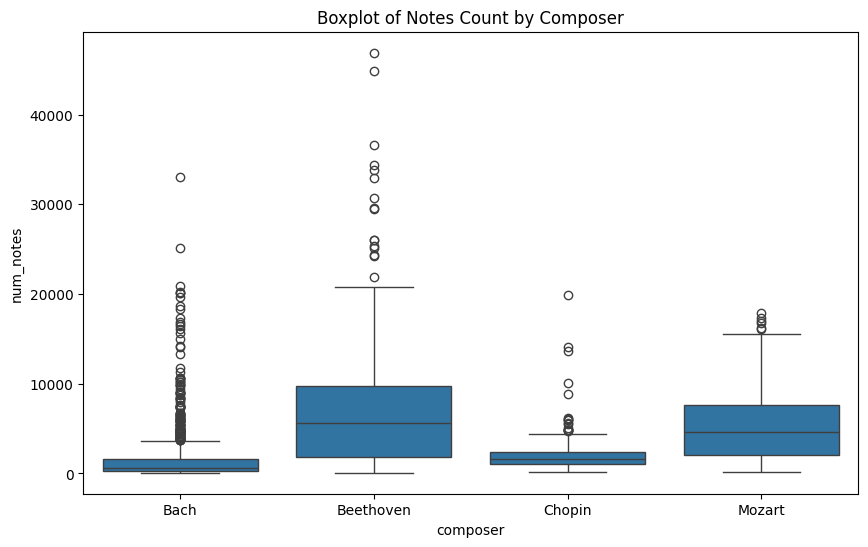

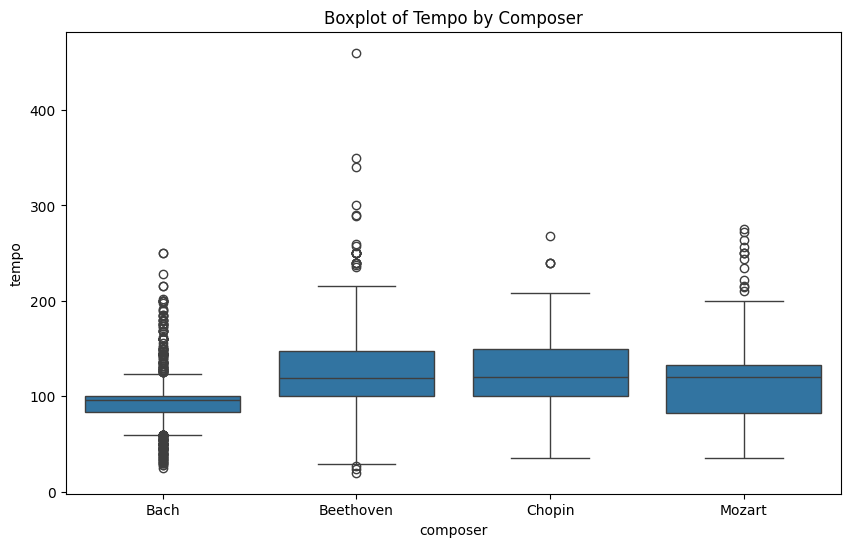

In [17]:
perform_eda(df_midi)

In [18]:
df_midi_clean = preprocess_data(df_midi)
print("\n Cleaned MIDI DataFrame (Sample):")
display(df_midi_clean.head())


 Cleaned MIDI DataFrame (Sample):


,composer,file_path,duration,num_instruments,num_notes,note_density,avg_velocity,min_pitch,max_pitch,avg_pitch,...,tempo,key_signature,time_signature,note_sequence,piano_roll,chroma,onset,rhythm,log_duration,log_notes
0,Bach,.\data\Bach\003706b_.mid,46.956456,4,304,6.474083,96.0,45,76,60.944079,...,92.000129,9.0,4/4,"[[1.9565190000000001, 69.0, 0.6521729999999999...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3.870293,5.720312
1,Bach,.\data\Bach\003806b_.mid,45.000000,4,253,5.622222,96.0,38,74,60.992095,...,96.000000,21.0,4/4,"[[0.0, 71.0, 1.25, 96.0], [0.0, 64.0, 1.25, 96...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3.828641,5.537334
2,Bach,.\data\Bach\003907bv.mid,42.500000,4,285,6.705882,96.0,40,76,59.182456,...,96.000000,7.0,4/4,"[[0.0, 67.0, 0.625, 96.0], [0.0, 62.0, 0.625, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3.772761,5.655992
3,Bach,.\data\Bach\003907b_.mid,42.500000,4,285,6.705882,96.0,43,79,62.182456,...,96.000000,10.0,4/4,"[[0.0, 70.0, 0.625, 96.0], [0.0, 65.0, 0.625, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3.772761,5.655992
4,Bach,.\data\Bach\004003b_.mid,30.000000,4,204,6.800000,96.0,42,74,61.220588,...,96.000000,19.0,4/4,"[[1.875, 67.0, 0.3125, 96.0], [1.875, 62.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3.433987,5.323010
